# DeepVoxNet 2: Yet another CNN framework

# 1. Introduction
Yes, we are introducing yet another CNN framework.
However, to the best of our knowledge there are no libraries that stay true to the aspects that we introduced in Section 1 in the previous chapter.
The main driver behind the creation of DeepVoxNet2 (DVN2) was that we wanted to make something that gives insights, rather than something that is super efficient or fully self-configuring (e.g. nnU-Net).

# 2. Installation
The DVN2 repository can be installed as a Python library such that all dependencies are also configured correctly.
In fact, even when you do not want to use the functionalities of DVN2 explicitly, installing it will provide users with a complete and working Python environment for doing medical image analysis in general.
As of now, it is best to add DVN2 to an empty Python 3.9 environment, e.g. using the Anaconda package manager to first create and activate such an environment via:
```
conda create --name dvn2env python=3.9
conda activate dvn2env
```
Once you have activated your Python 3.9 environment correctly, there are two options to install DVN2 together with al its dependencies, and as a result make your environment medical image analysis proof:

- First cloning or downloading the repository and then via:
```
pip install -e /path/to/deepvoxnet2
```
- Installing it directly from Github via:
```
pip install git+https://github.com/JeroenBertels/deepvoxnet2
```

The first method is particularly useful if you want to develop and contribute to the DVN2 library yourself.
To upgrade your installation using the first method, simply download the latest version and repeat the process or ```git pull``` the new version.
When using the second method simply repeat the command but add the ```--upgrade``` flag.
You can also install or revert to a specific version of DVN2. In that case, append ```@version_tag``` (e.g. *\@deepvoxnet-2.12.1*) to the paths in the above commands.
Some functions require the SimpleITK and SimpleElastix software to be installed. To install these packages, please append the paths in the above commands with ```[sitk]```.
These are not installed by default because they are only available for a limited number of operating systems.

# 2. Schematic overview
blabla

# 3. The Sample object
One of the core objects of DVN2 is the Sample object.
In line with the definitions of $X$ and $Y$ from the previous chapter, the Sample represents an array with a batch axis $\mathcal{B}$, a spatial axis $\mathcal{I}$ and a feature axis $\mathcal{F}$.
The spatial axis itself is 3D, hence the Sample object is a 5D array of size B x $\mathrm{I}_0$ x $\mathrm{I}_1$ x $\mathrm{I}_2$ x F.
Different from the standard Numpy array, the Sample object also has an affine attribute.
This affine attribute stores the voxel-to-world transformation matrix for each batch element.
As a result, the affine is a 3D array of size B x 4 x 4, thus assuming the same voxel-to-world transformation for each feature $f$ given a batch element $b$.

In [23]:
import numpy as np
from deepvoxnet2.components.sample import Sample

array_of_ones = np.ones((2, 100, 100, 3))
sample_of_ones = Sample(array_of_ones, affine=None)
print(sample_of_ones.shape)
print(sample_of_ones.affine)

(1, 2, 100, 100, 3)
[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]


It should be clear that upon creation the Sample object makes sure the underlying array is 5D and that an affine is specified.
Therefore, be careful and be specific.
It is best practice to always fully provide the 5D array and affine yourself to avoid unexpected behavior.
In that sense, when you are indeed working with only two spatial dimensions, it would be straightforward to set the fourth dimension of the Sample object as the singleton dimension.

In [24]:
default_affine = np.eye(4)
sample_of_ones = Sample(array_of_ones[:, :, :, None, :], affine=np.stack([default_affine] * 2, axis=0))
print(sample_of_ones.shape)
print(sample_of_ones.affine)

(2, 100, 100, 1, 3)
[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]


It is possible that you have a medical image, for example in Nifti format, and that you want to convert this into a Sample object.
In this case, you can load the image and use the internal data and affine to create the Sample.
Below we do this for the FLAIR image and the ground truth whole tumor segmentation (GT) of the first subject.
It should not be surprising that both the FLAIR and GT are equal in size and have the same voxel-to-word transformation.

In [25]:
import os
import nibabel as nib
from deepvoxnet2 import DEMO_DIR  # modify the DEMO_DIR accordingly

flair_path = os.path.join(DEMO_DIR, "brats_2018", "case_0", "FLAIR.nii.gz")
flair_image = nib.load(flair_path)
print(flair_image.shape)
print(flair_image.affine)
flair_sample = Sample(flair_image.get_fdata()[None, ..., None], affine=flair_image.affine[None, ...])
print(flair_sample.shape)
print(flair_sample.affine)
gt_path = os.path.join(DEMO_DIR, "brats_2018", "case_0", "GT_W.nii.gz")
gt_image = nib.load(gt_path)
gt_sample = Sample(gt_image.get_fdata()[None, ..., None], affine=gt_image.affine[None, ...])
print(gt_sample.shape)
print(gt_sample.affine)

(240, 240, 155)
[[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
(1, 240, 240, 155, 1)
[[[ -1.  -0.  -0.   0.]
  [ -0.  -1.  -0. 239.]
  [  0.   0.   1.   0.]
  [  0.   0.   0.   1.]]]
(1, 240, 240, 155, 1)
[[[ -1.  -0.  -0.   0.]
  [ -0.  -1.  -0. 239.]
  [  0.   0.   1.   0.]
  [  0.   0.   0.   1.]]]


# 4. Organizing the data
Now that we have defined the Sample object, which can represent any $x$ or $y$, we now want to start organizing our data, starting with the set $\mathcal{S}'$.
Remember that the set $\mathcal{S}'$ represents pairs of native images (e.g. samples drawn from the distribution ($\mathcal{X},\mathcal{Y}$)) rather than pairs that will be processed by the CNN.
For this purpose we have created a hierarchical structure of dictionaries: Mirc > Dataset > Case > Record > Modality.
When creating instantiations of a Dataset, Case, Record or Modality, we will need to specify an ID.
As a result, each dictionary consists of key-value pairs, with the keys corresponding to the lower level object's IDs.
The purpose of the Mirc object is to group multiple Dataset objects and provide the user with higher-level functionalities of which we will explain a few at the end of this section.

## 4.1 The Modality object
Starting from the lowest level, a Modality is simply something that returns a Sample object when ```load()``` is called.
This is useful because when having a large dataset, it is not possible to load every image at the same time, and thus the ```load``` method provides a way to only create a Sample object from it when needed.
Note that the Modality is an abstract class, and to really make use of the aforementioned feature, we should e.g. use the NiftiFileModality.
When the dataset is small, or for e.g. metadata such as age, it could be more efficient or appropriate to load everything to disk and use the NiftiModality or ArrayModality instead.
Other Modality subtypes that are readily available are ImageFileModality and ImageFileMultiModality.
These use the Image library to load 2D images from disk (e.g. PNG, JPG) and convert them to 5D correctly (setting the fourth dimension as the singleton dimension as mentioned before).

In [26]:
from deepvoxnet2.components.mirc import NiftiFileModality, NiftiModality, ArrayModality

flair_modality = NiftiFileModality("flair", file_path=flair_path)
flair_modality_ = NiftiModality("flair", nifty=flair_image)
flair_modality__ = ArrayModality("flair", array=flair_image.get_fdata(), affine=flair_image.affine)
assert np.array_equal(flair_modality.load(), flair_modality_.load())
assert np.array_equal(flair_modality.load(), flair_modality__.load())
print(flair_modality.load().shape)
print(flair_modality.load().affine)
gt_modality = NiftiFileModality("gt", file_path=flair_path)
metadata_modality = ArrayModality("age", array=45)  # just an example how we could make a metadata Sample, e.g. of age
print(metadata_modality.load().shape)
print(metadata_modality.load().affine)

(1, 240, 240, 155, 1)
[[[ -1.  -0.  -0.   0.]
  [ -0.  -1.  -0. 239.]
  [  0.   0.   1.   0.]
  [  0.   0.   0.   1.]]]
(1, 1, 1, 1, 1)
[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]


## 4.2 The Record, Case and Dataset objects
To create pairs of data, we should group multiple Modality objects under a so-called Record.
On its turn, multiple Record objects need to be grouped under a Case object.
The idea between the existence of both a Case and a Record is that there might be multiple *records* (e.g. observations) for a certain *case* (e.g. a subject).
Imagine that you have multiple experts annotating the same subject or that you have multiple parts of the body scanned separately.
Finally, cases should be grouped under a Dataset object.
Let's construct a tumor dataset based on data of 10 subjects from BRATS 2018 below.

In [27]:
from deepvoxnet2.components.mirc import Dataset, Case, Record

def get_tumor_dataset(dataset_id, case_indices):
    tumor_dataset = Dataset(dataset_id)
    for i in case_indices:
        subject = Case(f"subject_{i}")
        for j in range(1):  # we only have a single observation for each subject here
            observation = Record(f"observation_{j}")
            flair_modality = NiftiFileModality("flair", file_path=os.path.join(DEMO_DIR, "brats_2018", f"case_{i}", "FLAIR.nii.gz"))
            gt_modality = NiftiFileModality("gt", file_path=os.path.join(DEMO_DIR, "brats_2018", f"case_{i}", "GT_W.nii.gz"))
            age_modality = ArrayModality("age", np.random.randint(20, 80))
            observation.add(flair_modality)
            observation.add(gt_modality)
            observation.add(age_modality)
            subject.add(observation)

        tumor_dataset.add(subject)

    return tumor_dataset

tumor_dataset = get_tumor_dataset("train_dataset", range(8))
print(f"{tumor_dataset.dataset_id} contains {len(tumor_dataset)} cases:")
for case_id in tumor_dataset:
    print(f"\t{case_id} contains {len(tumor_dataset[case_id])} records:")
    for record_id in tumor_dataset[case_id]:
        print(f"\t\t{record_id} contains {len(tumor_dataset[case_id][record_id])} modalities:")
        for modality_id in tumor_dataset[case_id][record_id]:
            print(f"\t\t\t{modality_id}")

train_dataset contains 8 cases:
	subject_0 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_1 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_2 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_3 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_4 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_5 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_6 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_7 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt


## 4.3 The Mirc object
When we have build our dataset, we can group it, optionally with other datasets, into a Mirc object.
The Mirc object is a powerful tool to get a complete overview of all your data.
Calling ```get_dataset_ids()```, ```get_case_ids()```, ```get_record_ids()``` or ```get_modality_ids()``` you can get a quick overview on what data is available in your Mirc object.
You can also calculate the mean and standard deviation for a particular modality by using the ```mean_and_std``` method.
The ```inspect``` method is particularly useful to check multiple modalities for spatial consistency and get an overview of the distribution of voxel sizes and other spatial characteristics of your data.
Using the ```get_df``` method it is possible to acquire a Pandas DataFrame such that you could do other types of analyses or inspections.
This is particularly useful if you want to inspect distributions of non-imaging data, such as age.

['train_dataset', 'val_dataset']
['subject_0', 'subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9']
['observation_0']
['age', 'flair', 'gt']
(26.520628640232975, 66.88867846141157)
Total number of different dataset ids: 2
Total number of different case ids: 10
Total number of different record ids: 1
Total number of different modality ids: 2


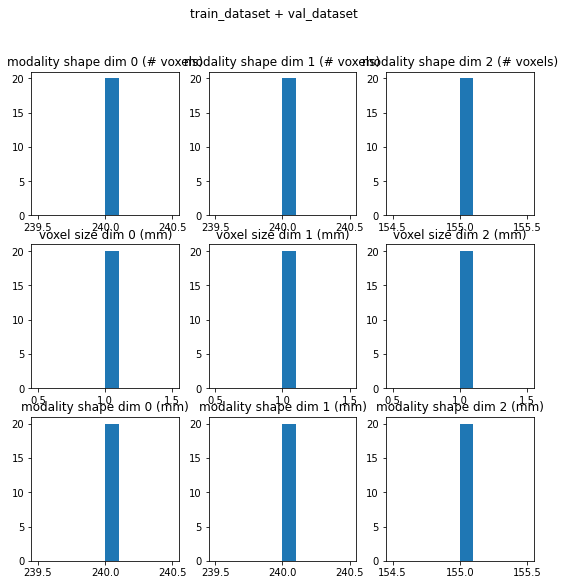

Mean and standard deviation of 'flair': (26.520628640232975, 66.88867846141157)
Mean and standard deviation of 'gt': (0.013233926971326165, 0.11427506354513185)


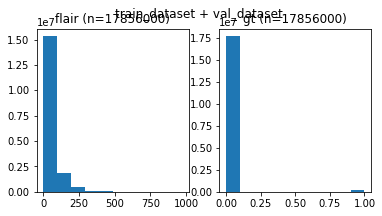

None
modality_id                                      age
dataset_id    case_id   record_id                   
train_dataset subject_0 observation_0  [[[[[57.]]]]]
              subject_1 observation_0  [[[[[38.]]]]]
              subject_2 observation_0  [[[[[76.]]]]]
              subject_3 observation_0  [[[[[61.]]]]]
              subject_4 observation_0  [[[[[23.]]]]]
              subject_5 observation_0  [[[[[61.]]]]]
              subject_6 observation_0  [[[[[78.]]]]]
              subject_7 observation_0  [[[[[42.]]]]]
val_dataset   subject_8 observation_0  [[[[[41.]]]]]
              subject_9 observation_0  [[[[[43.]]]]]


In [28]:
from deepvoxnet2.components.mirc import Mirc

train_tumor_dataset = tumor_dataset
val_tumor_dataset = get_tumor_dataset("val_dataset", range(8, 10))
my_mirc = Mirc(train_tumor_dataset, val_tumor_dataset)
print(my_mirc.get_dataset_ids())
print(my_mirc.get_case_ids())
print(my_mirc.get_record_ids())
print(my_mirc.get_modality_ids())
print(my_mirc.mean_and_std("flair", n=2))  # computing the mean and standard deviation using all your images might be too expensive, therefore limit the number of images used setting the n option
print(my_mirc.inspect(["flair", "gt"], ns=[2, 2]))
print(my_mirc.get_df("age"))

You might have noticed that we already gave the previously created ```tumor_dataset``` the ID *train_dataset*.
In a similar manner, we have now also created a *val_dataset*.
In the aforementioned usage example of the Mirc object we have grouped both our training and our validation set under one Mirc object.
Keep in mind that this was just for illustration purposes.
It is always a good idea to keep the two separate.

# 5. Data transformation
Once that we have defined the sets $\mathcal{S'}_\mathrm{train}$ and $\mathcal{S'}_\mathrm{val}$, e.g. by means of Mirc objects, we need to start thinking about the sampling function $s''$ that produces the learning or inference sets $\mathcal{S}_\mathrm{train}$ and $\mathcal{S}_\mathrm{val}$, respectively.
It turns out that we can often view $s''$ as first sampling a data pair, e.g. a Record from a Mirc object, and then applying some form of data transformation, e.g. cropping or more complex data augmentation.

At this point it should be clear that a Record is just another representation of a list of Sample objects, with the additional benefit that not all data needed to be loaded into memory and that it is more structured.
As a result, the sets $\mathcal{S}$ and $\mathcal{S'}$ are lists of Records, and thus lists of lists of Sample objects.
Indeed, this is exactly how the sets $\mathcal{S}$ and $\mathcal{S'}$ were defined in the previous chapter.

In DVN2, the first part is implemented by means of the Sampler object and will be discussed in the next section.
For now assume that we have selected a certain record and that we want to generate one or more learning pairs.

# 6. Data sampling

## 6.1 The Sampler object
We chose to define a Sampler as a rather simple object, more specifically a list of *identifiers*, but with some additional functionalities.
An Identifier object can be any object and will be discussed in the next subsection.
For now, you can view an identifier as a record.

## 6.2 The identifier object